# ReachBot Locomotion using A* Motion Planning - Extended from AA274a

In [1]:
# The autoreload extension will automatically load in new code as you edit files, 
# so you don't need to restart the kernel every time
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from P1_astar import DetOccupancyGrid2D, AStar
from utils import generate_planning_problem

## Simple Environment
### Workspace
(Try changing this and see what happens)

The resolution parameter "scale" is similar to the resolution parameter that's build-in to the Astar class in P1_astar.py. However, the Astar resolution fixes the boundaries of the map and adds more points at in-between decimal values on the grid. For my "scale" parameter, I wanted to keep every grid square to be of length 1 in order to mesh well with the ReachBot planning code. Instead, "scale" will scale up the map boundaries and obstacles accordingly to add more in-between squares for fine movement. I appended the modified variables with "_sc" for "scaled".

In [2]:
width = 10
height = 10
obstacles = [((6,7),(8,8)),((2,2),(4,3)),((2,5),(4,7)),((6,3),(8,5))]
occupancy = DetOccupancyGrid2D(width, height, obstacles)

scale = 4
width_sc = 10*scale
height_sc = 10*scale
obstacles_sc = [((6*scale, 7*scale), (8*scale, 8*scale)),\
             ((2*scale, 2*scale), (4*scale, 3*scale)),\
             ((2*scale, 5*scale), (4*scale, 7*scale)),\
             ((6*scale, 3*scale), (8*scale, 5*scale))]
occupancy_sc = DetOccupancyGrid2D(width_sc, height_sc, obstacles_sc)

### Starting and final positions
(Try changing these and see what happens)

In [3]:
x_init = (1, 1)
x_goal = (9, 9)

x_init_sc = (1*scale, 1*scale)
x_goal_sc = (9*scale, 9*scale)

### Run A* planning
The "buffer" parameter creates obstacle inflation to allow extra room around the obstacles for ReachBot to maneuver its legs.

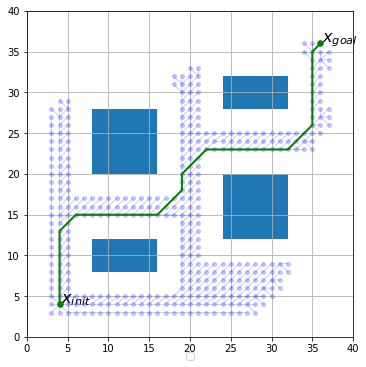

In [4]:
#astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy, resolution=0.1, buffer=0.2)
astar = AStar((0, 0), (width_sc, height_sc), x_init_sc, x_goal_sc, occupancy_sc, buffer=2)
if not astar.solve():
    print("No path found")
else:
    plt.rcParams['figure.figsize'] = [6, 6]
    astar.plot_path()
    astar.plot_tree()

### Generate subgoals from A* Path
The Bresenham algorithm returns a list of all grid squares which a continuous line paths through. (Note: According to this stackoverflow post https://stackoverflow.com/questions/3303936/how-to-find-all-grid-squares-on-a-line, Bresenham finds most of the grid squares along a line, but tends to miss some if the overlap is very small.)

Checking for line-of-sight with the occupancy grid should use the same buffer for inflated obstacles as was used to create the original path.

In [5]:
from bresenham import bresenham
import copy

def sight_line_clear(sub_init, path_point, astar):
    '''
    Check if all points intersected by a line-of-sight from sub_init to path_point are clear
    
    Parameter: sight_points, a list of all grid squares that the line of interest passes through
    Return: True, if line-of-sight is clear (i.e. none of these grid squares are occupied by the inflated obstacles)
    '''
    sight_points = list(bresenham(sub_init[0], sub_init[1], path_point[0], path_point[1]))
    for point in sight_points:
        if not astar.occupancy.is_free(point, buffer=2):
            return False
    return True

To find subgoals, first consider a line between the initial point to each subsequent point on the A* path. Check each line for a clear line-of-sight before moving on to the next. Once a path without a clear line-of-sight is reached, then the point immediately before it on the path is designated as the next subgoal. Keep a record of your remaining path-to-go (remove everything before the current subgoal) so that you know when you have reached the end of the path.

Subgoals List:
[(5, 14), (7, 15), (18, 17), (19, 19), (22, 23), (34, 25), (35, 27), (36, 36)]


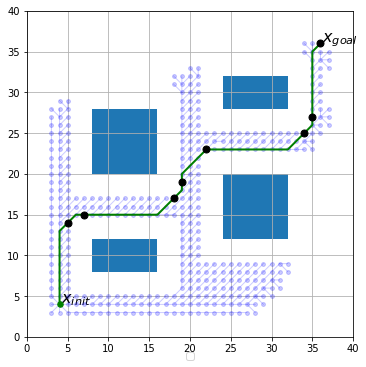

In [6]:
# Copy the path, b/c we will be continously removing points from "path_to_go" as we find subgoals further and further along
path_to_go = copy.copy(astar.path)

# Truncate .0 decimals to int's for Bresenham algorithm
for idx, point in enumerate(path_to_go):
    path_to_go[idx] = (int(point[0]), int(point[1]))

subgoals = []
while len(path_to_go) > 0:
    # The path is shortened so that the init for each new subproblem is now at the beginning of the path-to-go
    sub_init = path_to_go[0]

    # Test each point along the path-to-go for a clear line-of-sight. When the line-of-sight is broken, store subgoal
    for idx, path_point in enumerate(path_to_go):
        if not sight_line_clear(sub_init, path_point, astar):
            subgoals.append(path_to_go[idx-1]) # Save the last point with a clear line-of-sight as a subgoal
            path_to_go = path_to_go[idx-1:] # Shorten path to now begin at this subgoal, to consider just the remaining path-to-go
            break
        elif path_point == path_to_go[-1]:
            # When we reach the final point in path_to_go, we have reached the final goal and we're done
            subgoals.append(path_to_go[-1])
            path_to_go=[]

print "Subgoals List:"
print subgoals

plt.rcParams['figure.figsize'] = [6, 6]
astar.plot_path()
astar.plot_tree()
for goal in subgoals:
    plt.plot(goal[0], goal[1], color='black', marker='o', fillstyle='full', markersize=7, zorder=10)

### Solve for ReachBot Actions & Plot
If solving a problem without obstacles, then the following blocks are the only two that need to be run (aside from possibly defining your own list of subgoals).

Each subgoal defines the location of where to place ReachBot's body. To get a full goal state, we set the feet surrounding the body into default positions for each subproblem. In the future, the feet positions at the subgoal should be generated separately for each subproblem for optimal efficiency.

In [10]:
from solve_subproblem import solve_subproblem

def state_from_body(body):
    foot1 = (body[0] - 1, body[1] + 1)
    foot2 = (body[0] + 1, body[1] + 1)
    foot3 = (body[0] - 1, body[1] - 1)
    foot4 = (body[0] + 1, body[1] - 1)
    state = [foot1, foot2, foot3, foot4, body]
    return state

The set up below can be used to solve sequences of subproblems, or just a single problem from Point A to Point B. If solving a single problem, set up the goal similar to the block comment. In this case, the "astar" parameter of solve_subproblem() can be either left out or set to "None".

After solving each subproblem, the initial state of the next subproblem is set to the previous subgoal. Also, the subgoal that was just reached was removed from "goals_remaining", which is then passed back in. "Goals_remaining" is used solely for plotting purposes.

Note: It is possible for the "solved" return of solve_subproblem() to come back False, a result of checking if the robot got stuck. "Stuck" is defined as going through a full cycle of the gait without updating any part of the state (foot nor body). We do not currently ensure that "solved" came back True, but in the future there should be a recovery routine to call when "solved" comes back False. Such a routine would in some way reset the positions of the feet around the body so that it can proceed in moving.

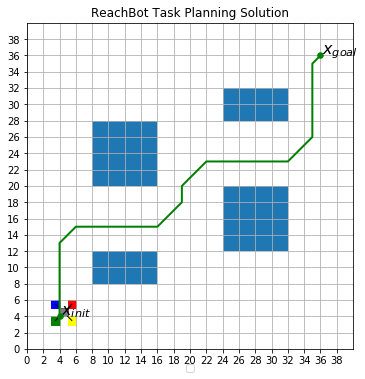

<Figure size 432x432 with 0 Axes>

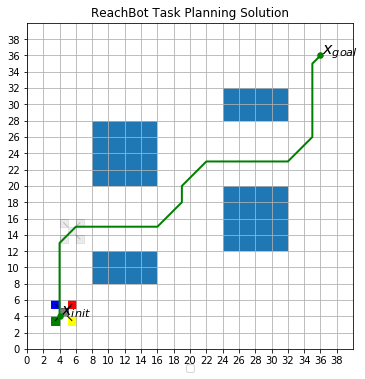

<Figure size 432x432 with 0 Axes>

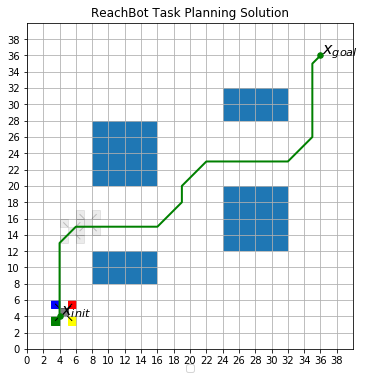

<Figure size 432x432 with 0 Axes>

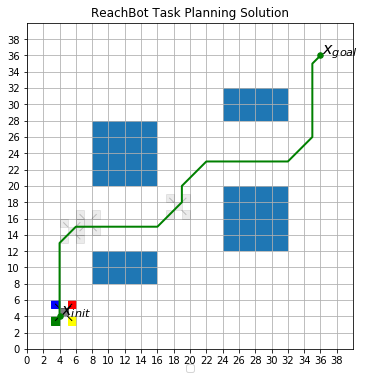

<Figure size 432x432 with 0 Axes>

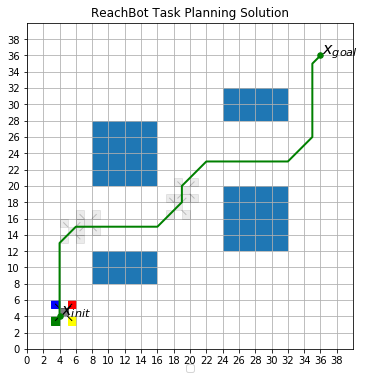

<Figure size 432x432 with 0 Axes>

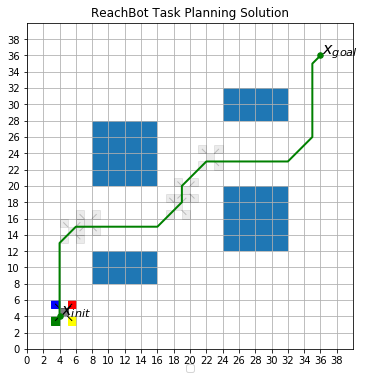

<Figure size 432x432 with 0 Axes>

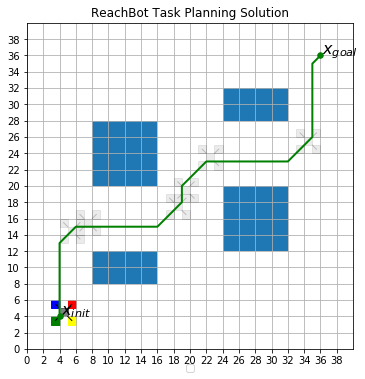

<Figure size 432x432 with 0 Axes>

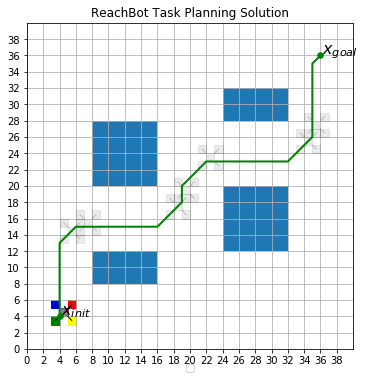

<Figure size 432x432 with 0 Axes>

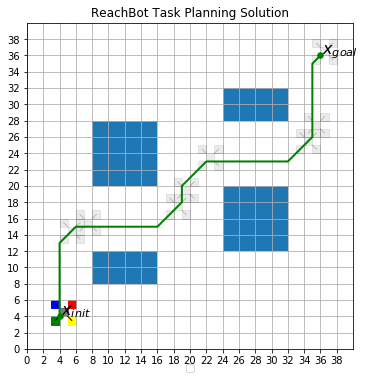

<Figure size 432x432 with 0 Axes>

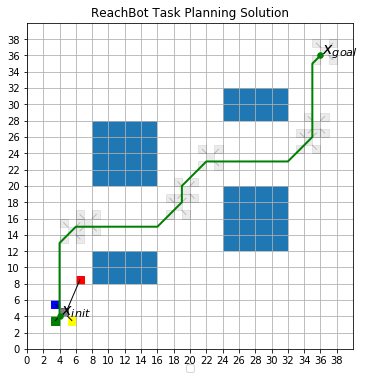

<Figure size 432x432 with 0 Axes>

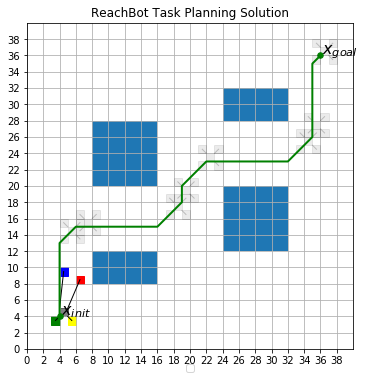

<Figure size 432x432 with 0 Axes>

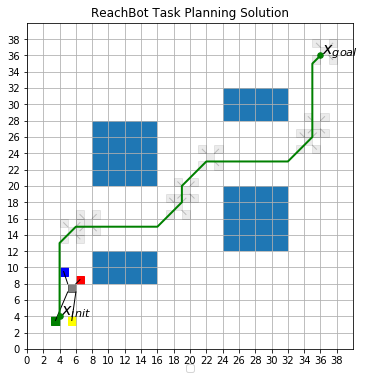

<Figure size 432x432 with 0 Axes>

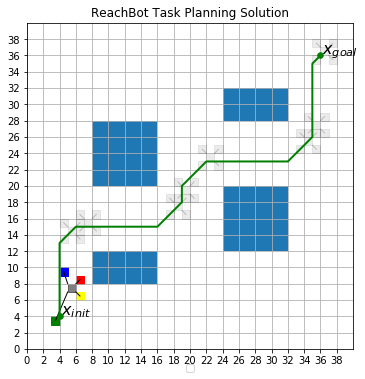

<Figure size 432x432 with 0 Axes>

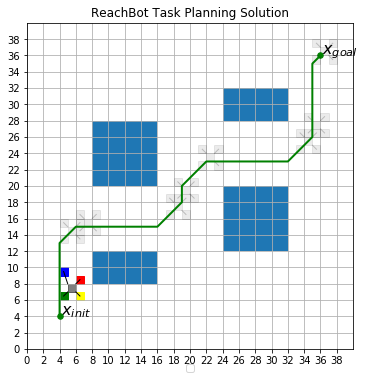

<Figure size 432x432 with 0 Axes>

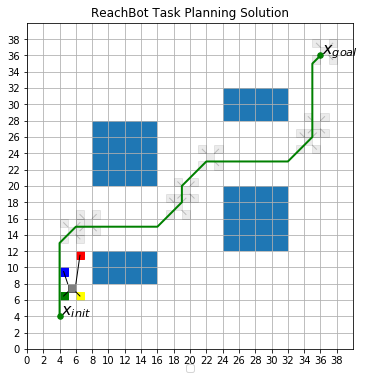

<Figure size 432x432 with 0 Axes>

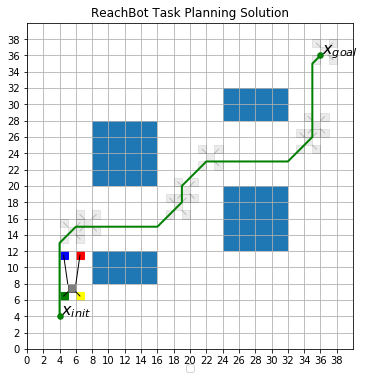

<Figure size 432x432 with 0 Axes>

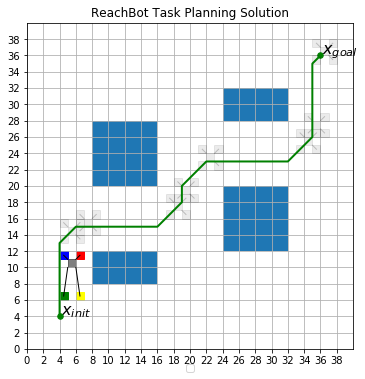

<Figure size 432x432 with 0 Axes>

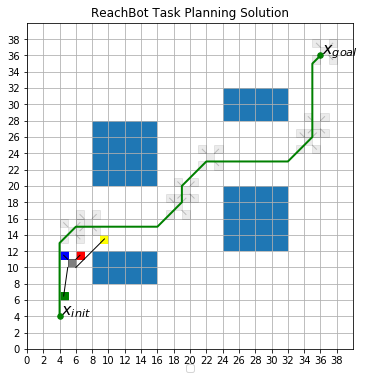

<Figure size 432x432 with 0 Axes>

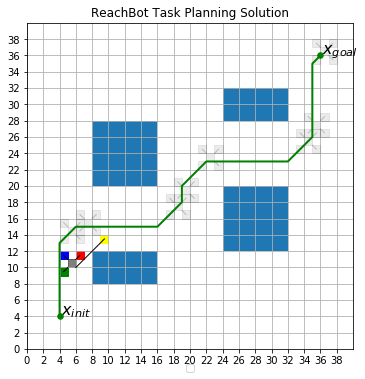

<Figure size 432x432 with 0 Axes>

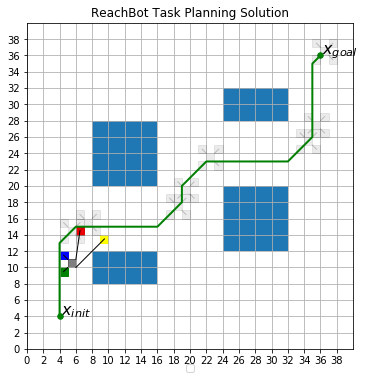

<Figure size 432x432 with 0 Axes>

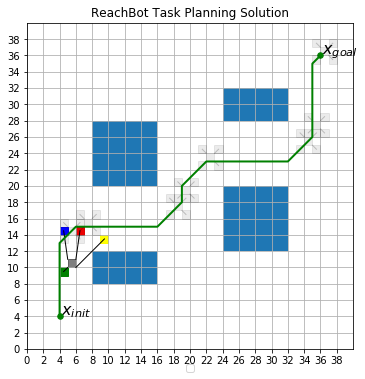

<Figure size 432x432 with 0 Axes>

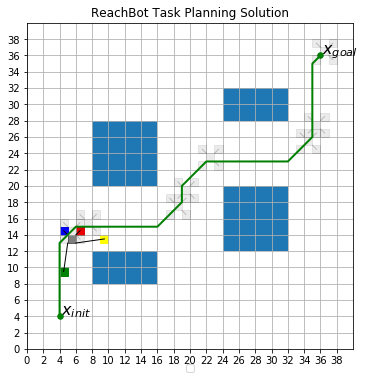

<Figure size 432x432 with 0 Axes>

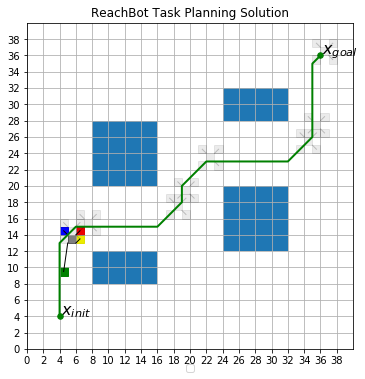

<Figure size 432x432 with 0 Axes>

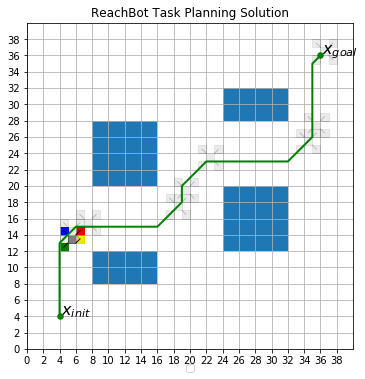

<Figure size 432x432 with 0 Axes>

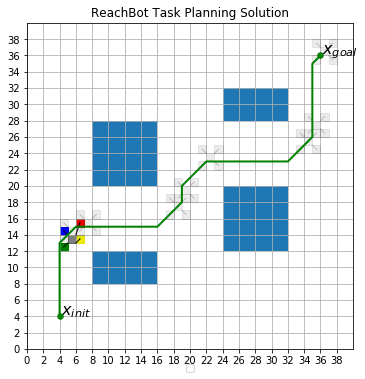

<Figure size 432x432 with 0 Axes>

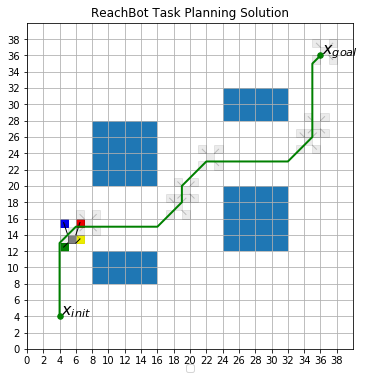

<Figure size 432x432 with 0 Axes>

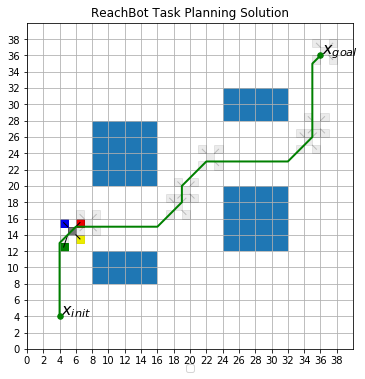

<Figure size 432x432 with 0 Axes>

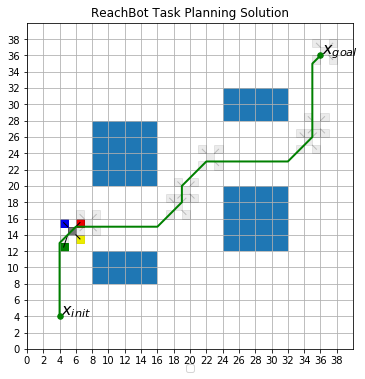

<Figure size 432x432 with 0 Axes>

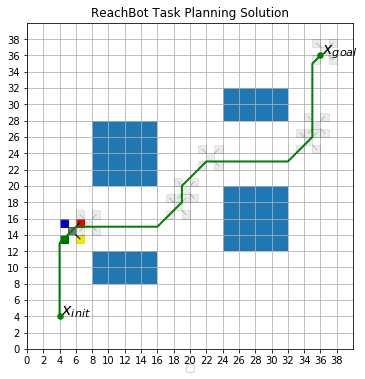

(31.77, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

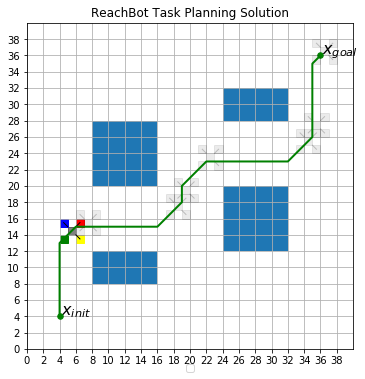

<Figure size 432x432 with 0 Axes>

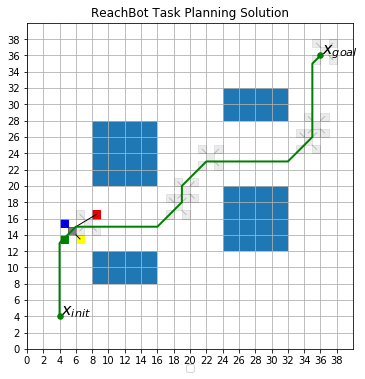

<Figure size 432x432 with 0 Axes>

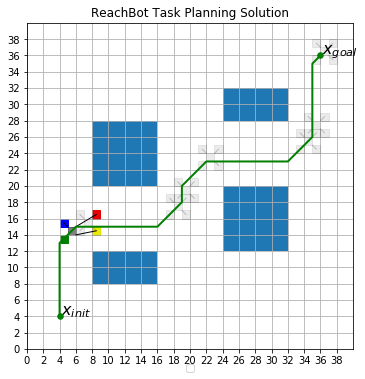

<Figure size 432x432 with 0 Axes>

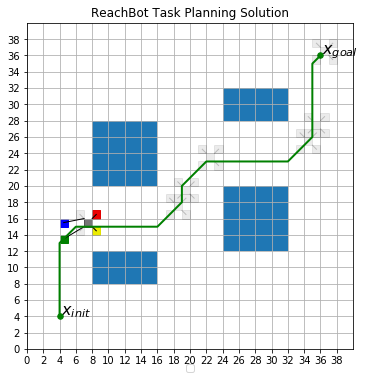

<Figure size 432x432 with 0 Axes>

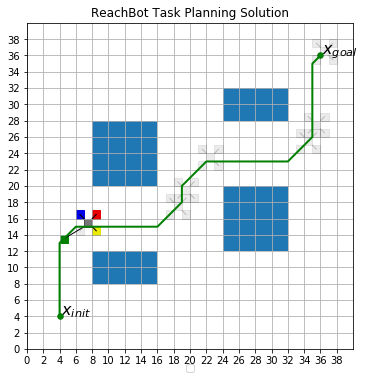

<Figure size 432x432 with 0 Axes>

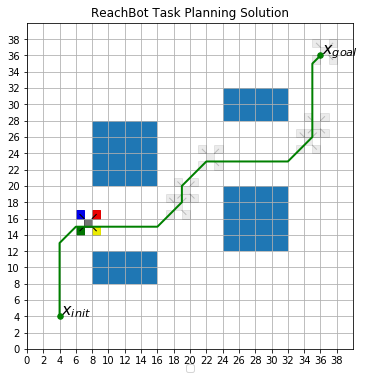

(6.78, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

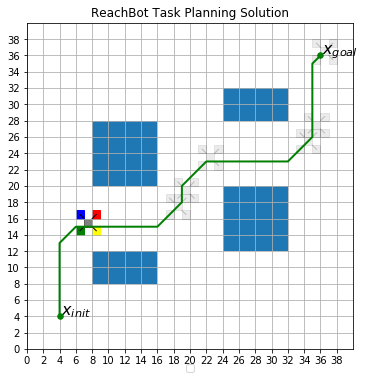

<Figure size 432x432 with 0 Axes>

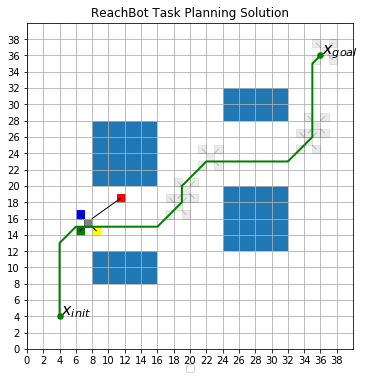

<Figure size 432x432 with 0 Axes>

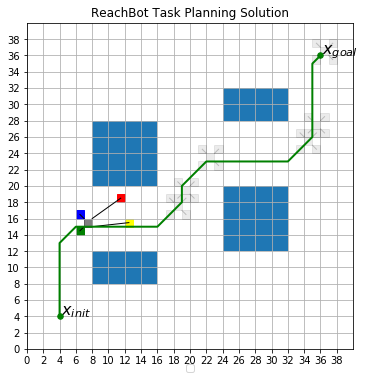

<Figure size 432x432 with 0 Axes>

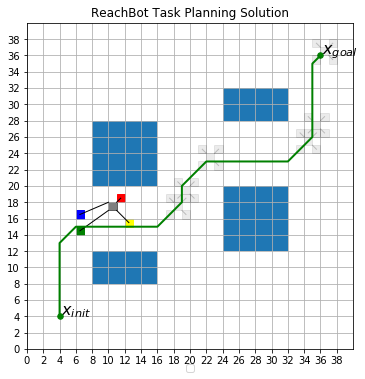

<Figure size 432x432 with 0 Axes>

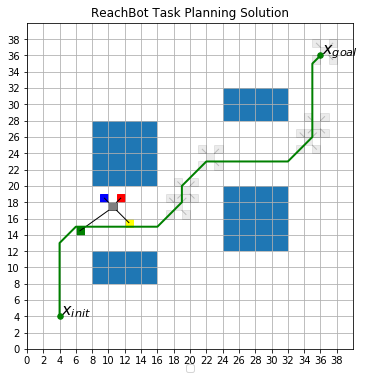

<Figure size 432x432 with 0 Axes>

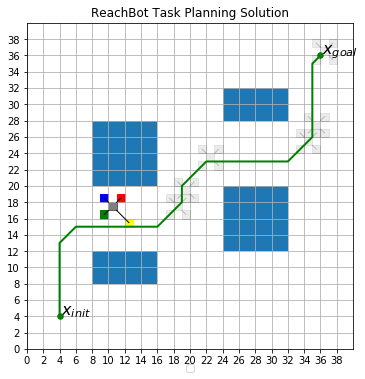

<Figure size 432x432 with 0 Axes>

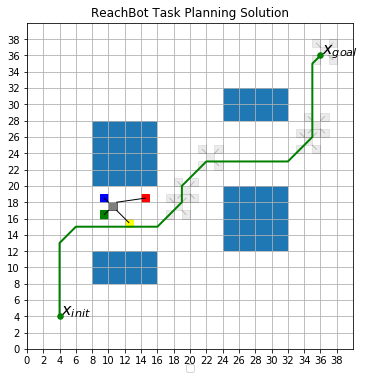

<Figure size 432x432 with 0 Axes>

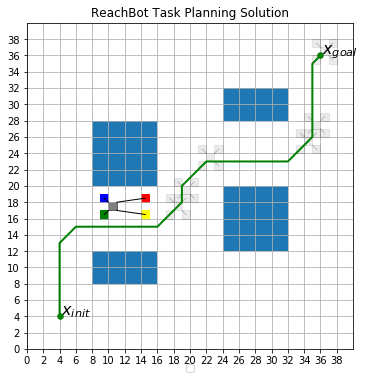

<Figure size 432x432 with 0 Axes>

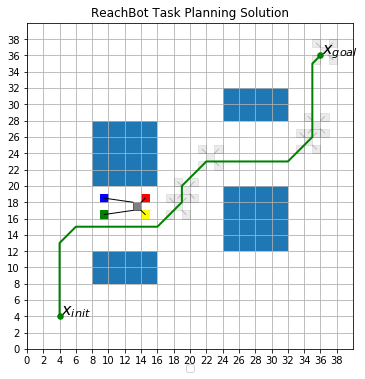

<Figure size 432x432 with 0 Axes>

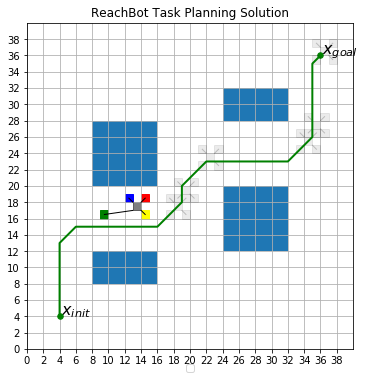

<Figure size 432x432 with 0 Axes>

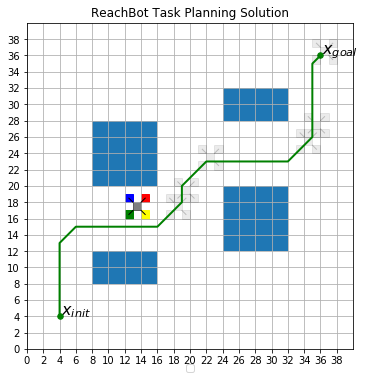

<Figure size 432x432 with 0 Axes>

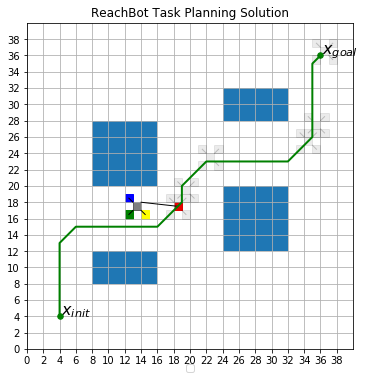

<Figure size 432x432 with 0 Axes>

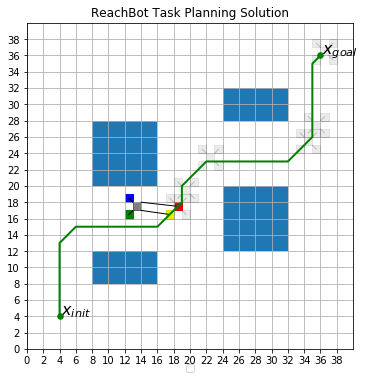

<Figure size 432x432 with 0 Axes>

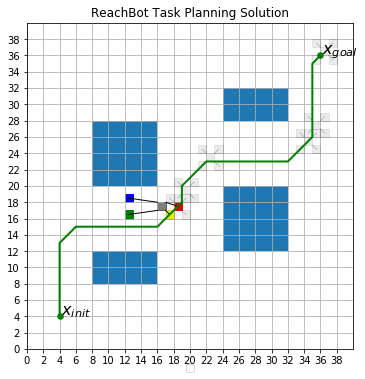

<Figure size 432x432 with 0 Axes>

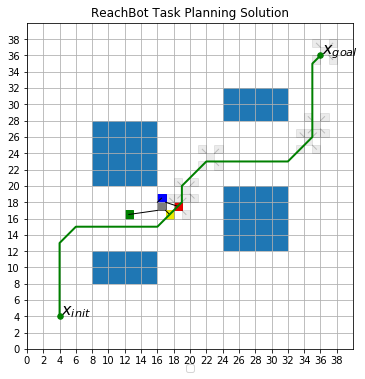

<Figure size 432x432 with 0 Axes>

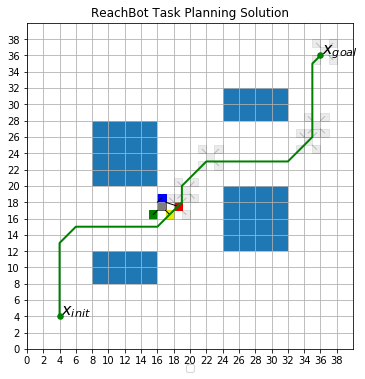

<Figure size 432x432 with 0 Axes>

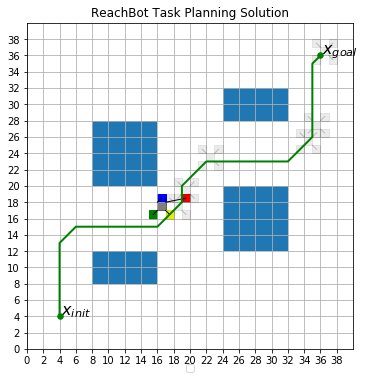

<Figure size 432x432 with 0 Axes>

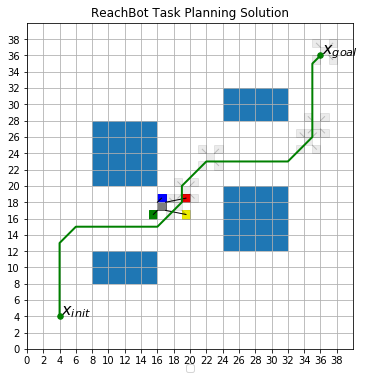

<Figure size 432x432 with 0 Axes>

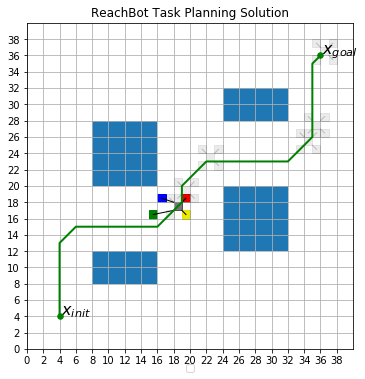

<Figure size 432x432 with 0 Axes>

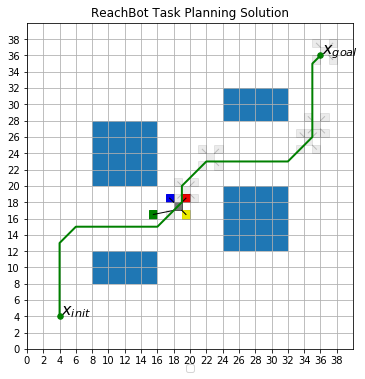

<Figure size 432x432 with 0 Axes>

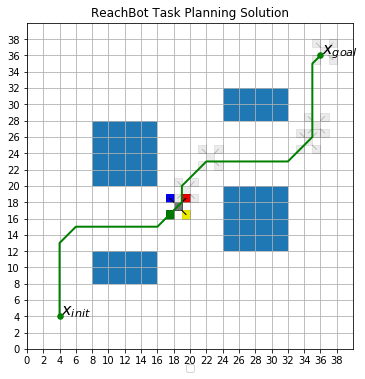

(22.84, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

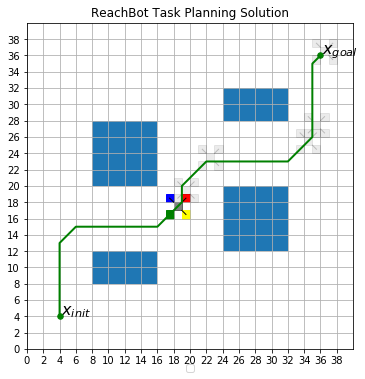

<Figure size 432x432 with 0 Axes>

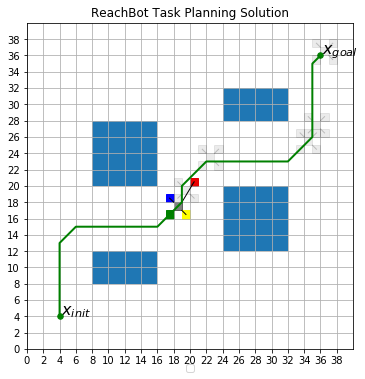

<Figure size 432x432 with 0 Axes>

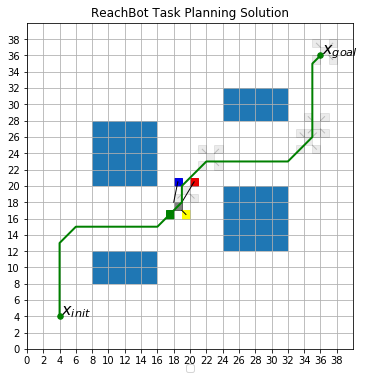

<Figure size 432x432 with 0 Axes>

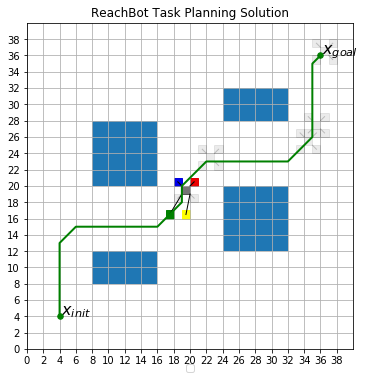

<Figure size 432x432 with 0 Axes>

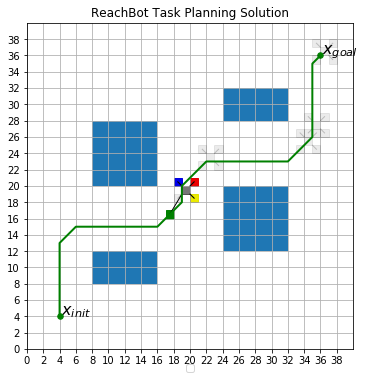

<Figure size 432x432 with 0 Axes>

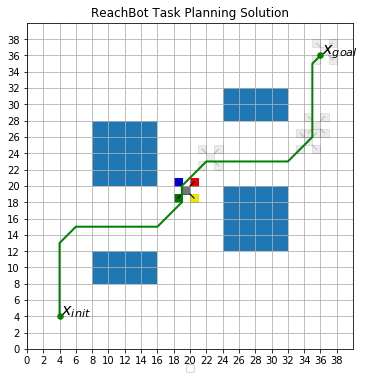

(6.55, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

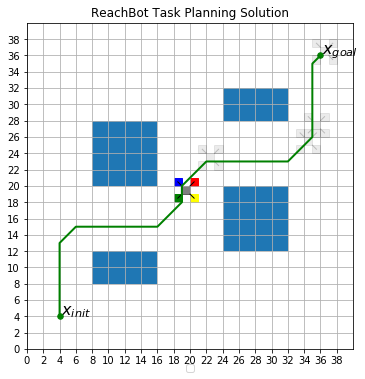

<Figure size 432x432 with 0 Axes>

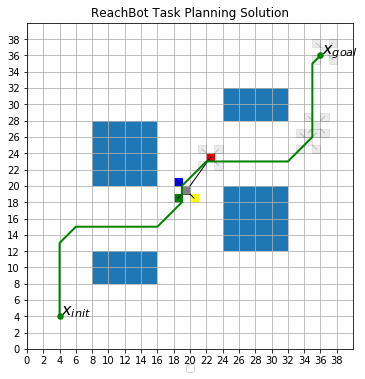

<Figure size 432x432 with 0 Axes>

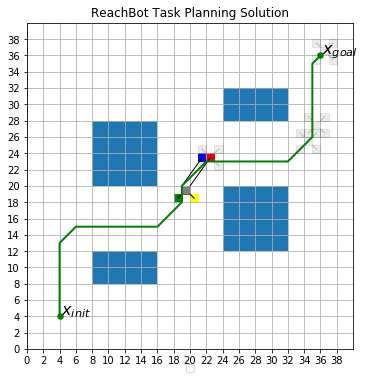

<Figure size 432x432 with 0 Axes>

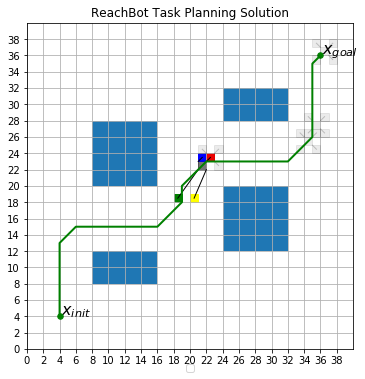

<Figure size 432x432 with 0 Axes>

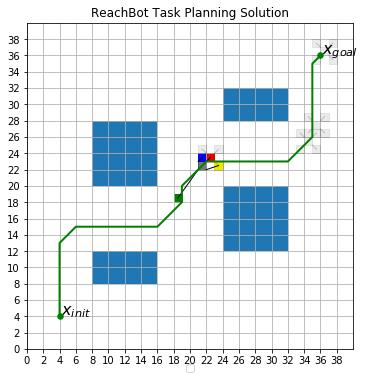

<Figure size 432x432 with 0 Axes>

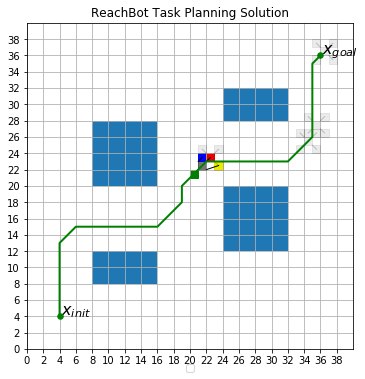

<Figure size 432x432 with 0 Axes>

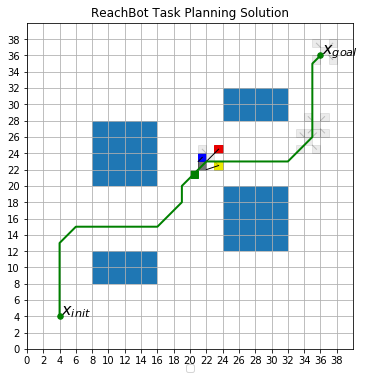

<Figure size 432x432 with 0 Axes>

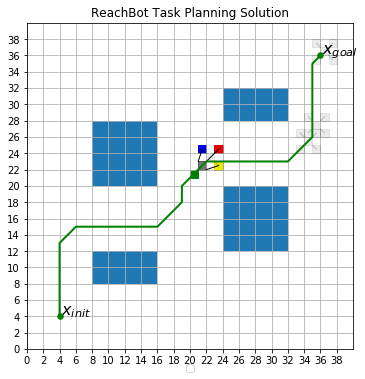

<Figure size 432x432 with 0 Axes>

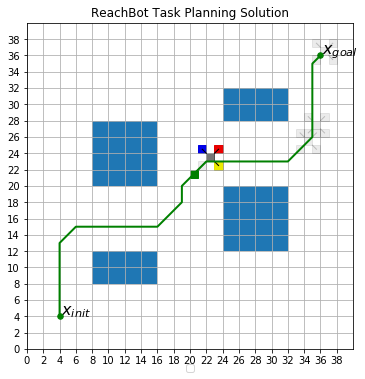

<Figure size 432x432 with 0 Axes>

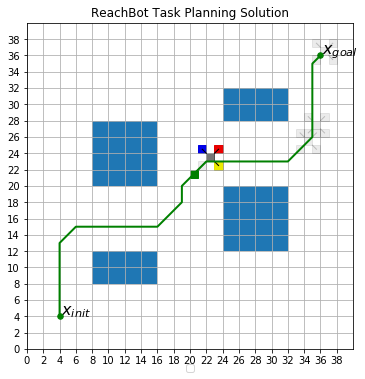

<Figure size 432x432 with 0 Axes>

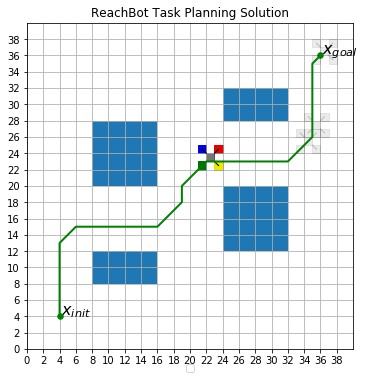

(11.72, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

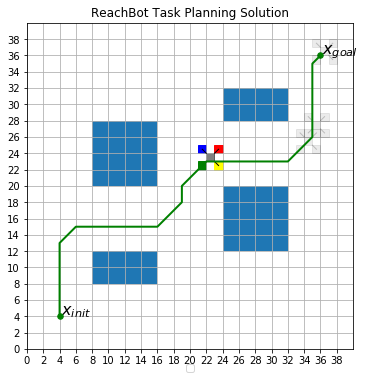

<Figure size 432x432 with 0 Axes>

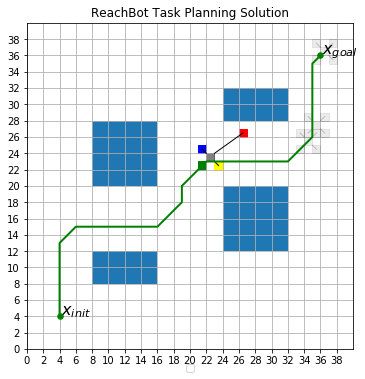

<Figure size 432x432 with 0 Axes>

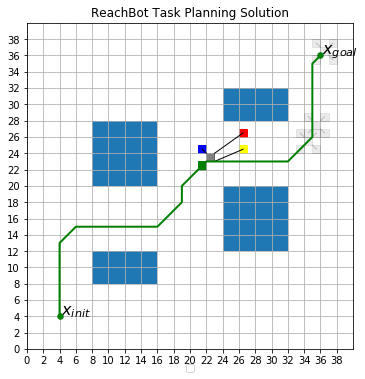

<Figure size 432x432 with 0 Axes>

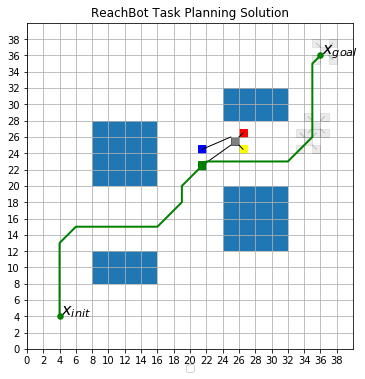

<Figure size 432x432 with 0 Axes>

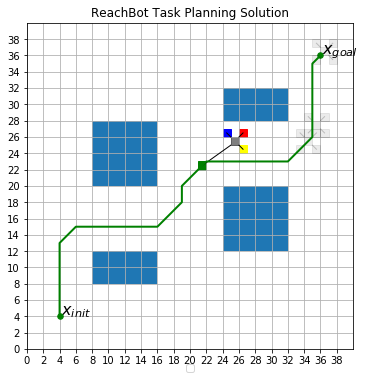

<Figure size 432x432 with 0 Axes>

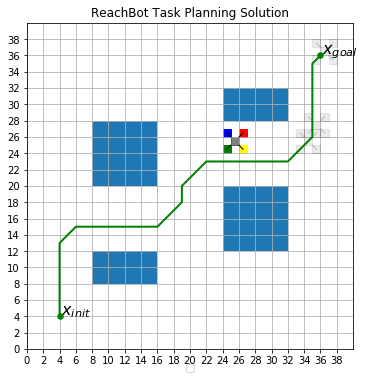

<Figure size 432x432 with 0 Axes>

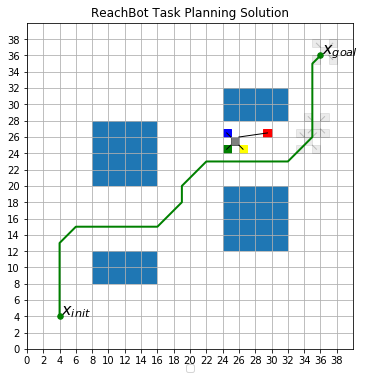

<Figure size 432x432 with 0 Axes>

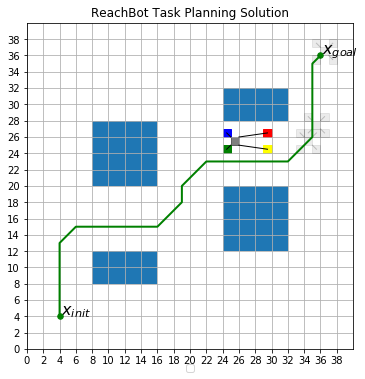

<Figure size 432x432 with 0 Axes>

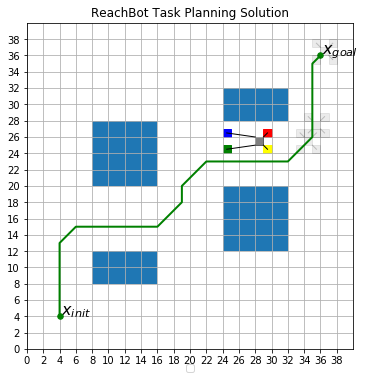

<Figure size 432x432 with 0 Axes>

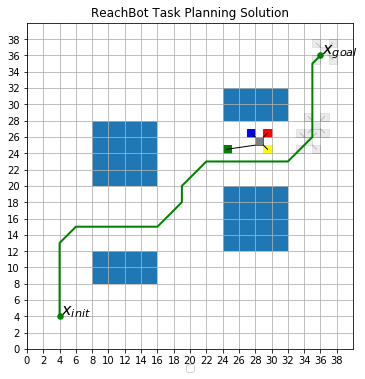

<Figure size 432x432 with 0 Axes>

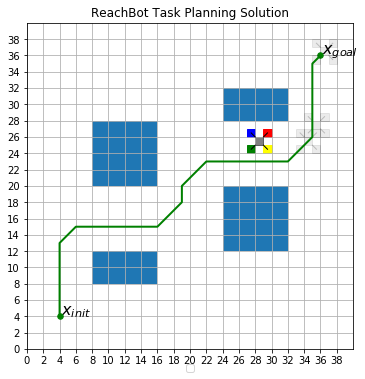

<Figure size 432x432 with 0 Axes>

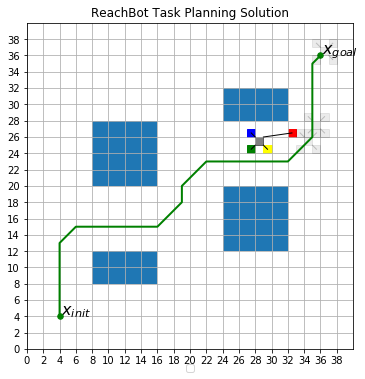

<Figure size 432x432 with 0 Axes>

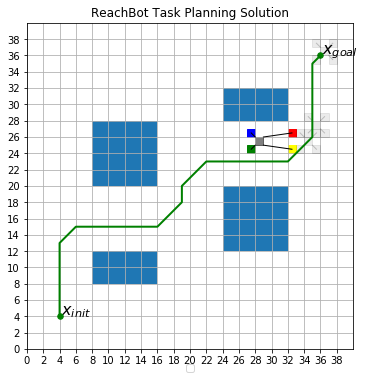

<Figure size 432x432 with 0 Axes>

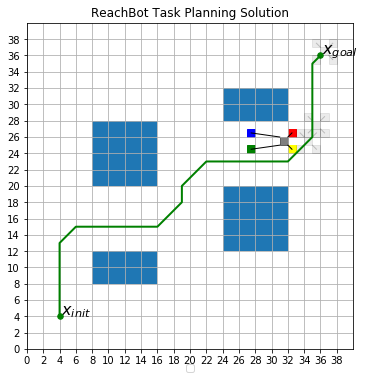

<Figure size 432x432 with 0 Axes>

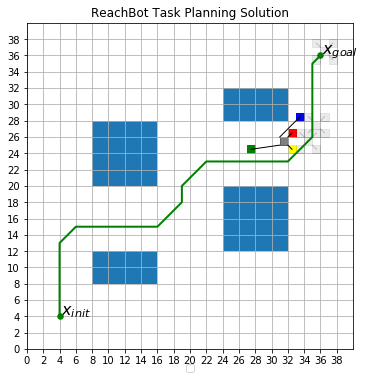

<Figure size 432x432 with 0 Axes>

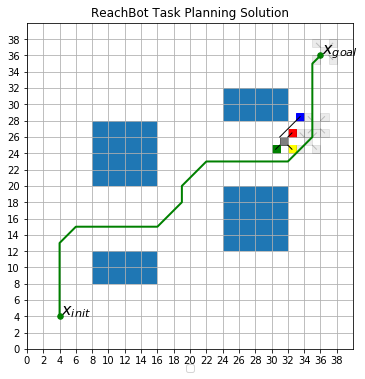

<Figure size 432x432 with 0 Axes>

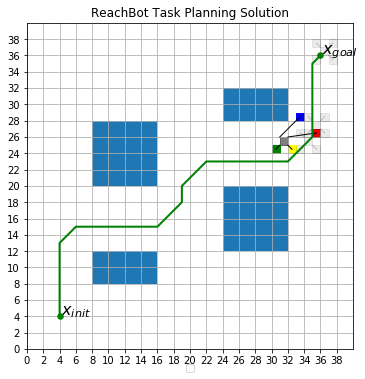

<Figure size 432x432 with 0 Axes>

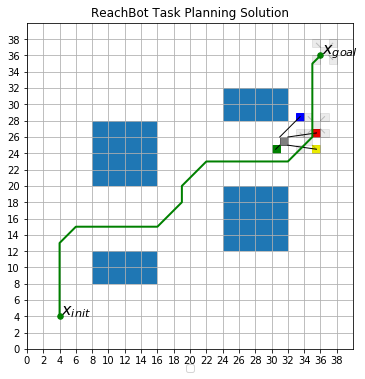

<Figure size 432x432 with 0 Axes>

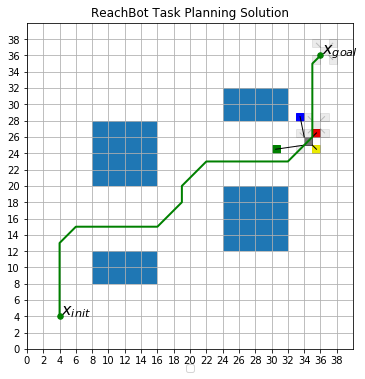

<Figure size 432x432 with 0 Axes>

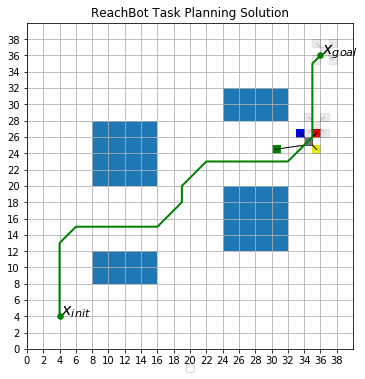

<Figure size 432x432 with 0 Axes>

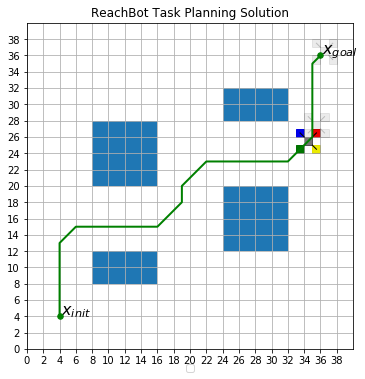

(21.63, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

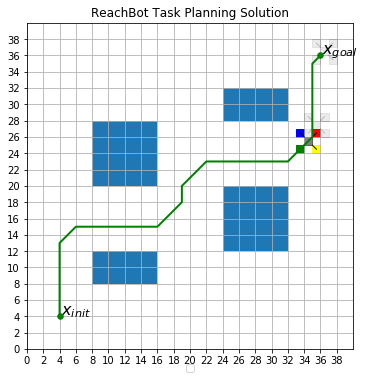

<Figure size 432x432 with 0 Axes>

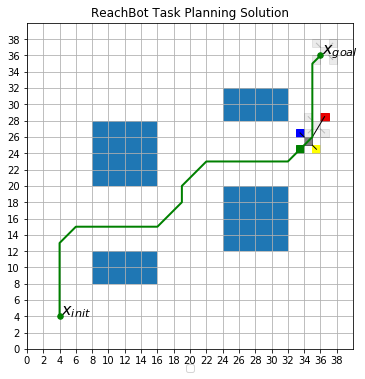

<Figure size 432x432 with 0 Axes>

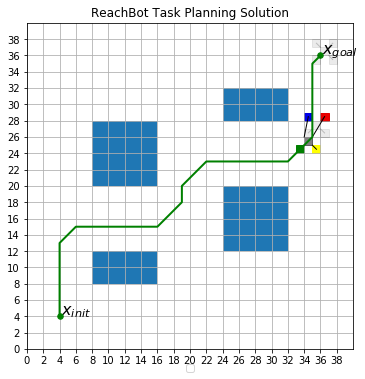

<Figure size 432x432 with 0 Axes>

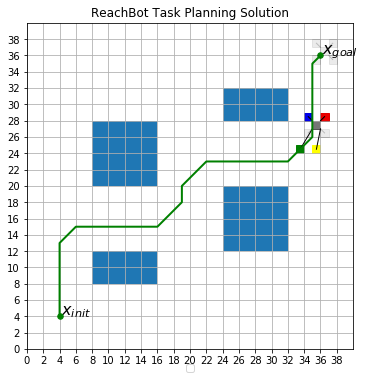

<Figure size 432x432 with 0 Axes>

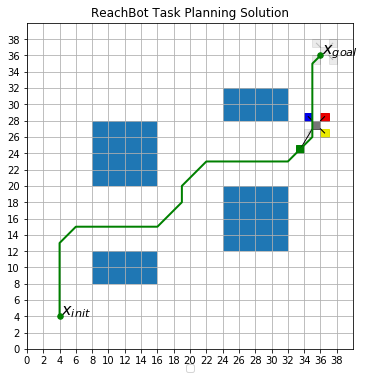

<Figure size 432x432 with 0 Axes>

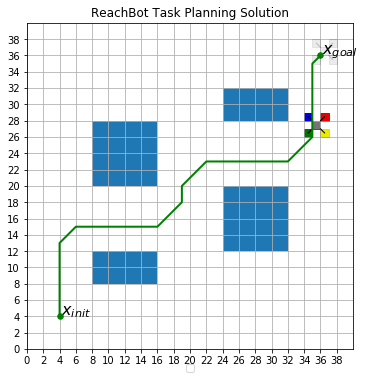

(6.06, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

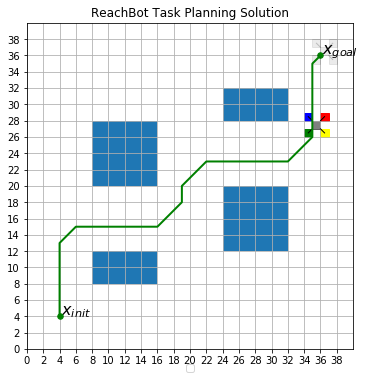

<Figure size 432x432 with 0 Axes>

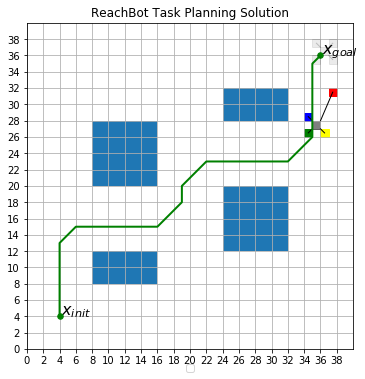

<Figure size 432x432 with 0 Axes>

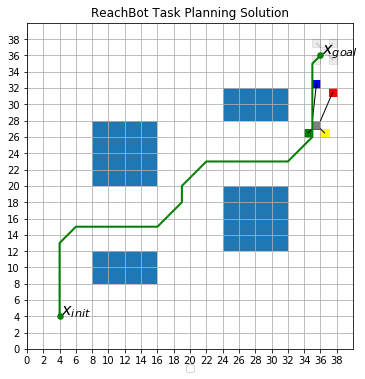

<Figure size 432x432 with 0 Axes>

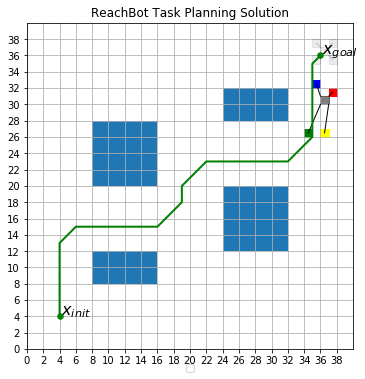

<Figure size 432x432 with 0 Axes>

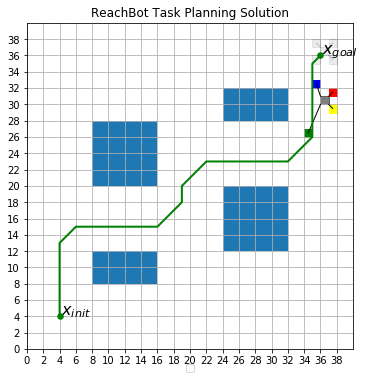

<Figure size 432x432 with 0 Axes>

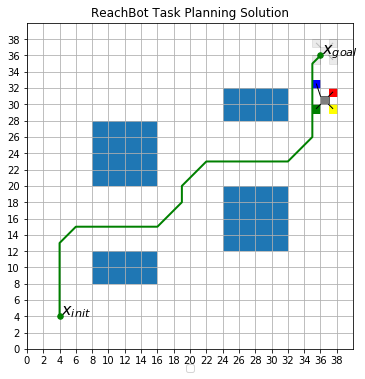

<Figure size 432x432 with 0 Axes>

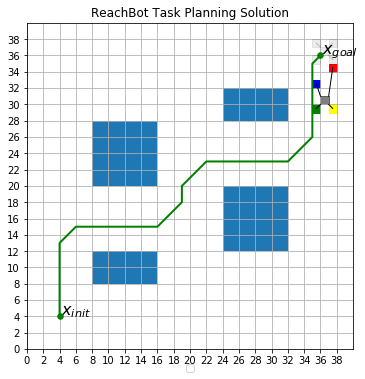

<Figure size 432x432 with 0 Axes>

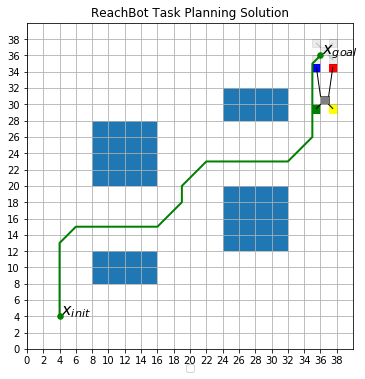

<Figure size 432x432 with 0 Axes>

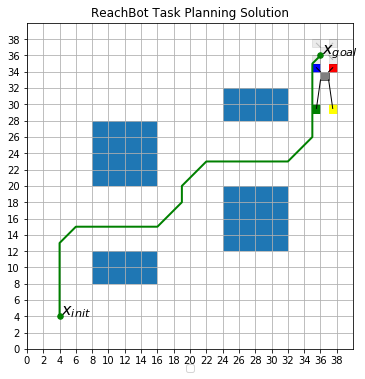

<Figure size 432x432 with 0 Axes>

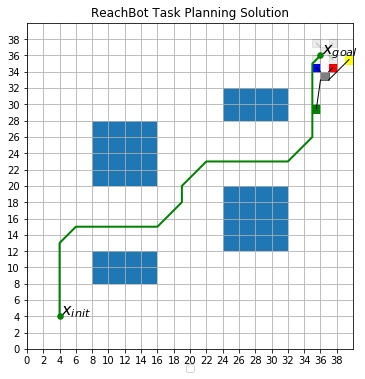

<Figure size 432x432 with 0 Axes>

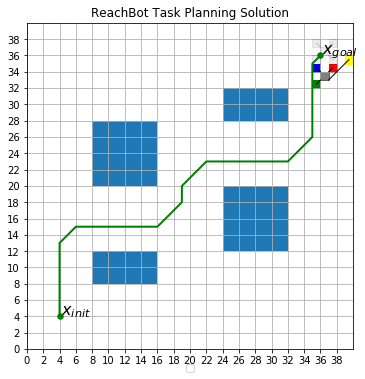

<Figure size 432x432 with 0 Axes>

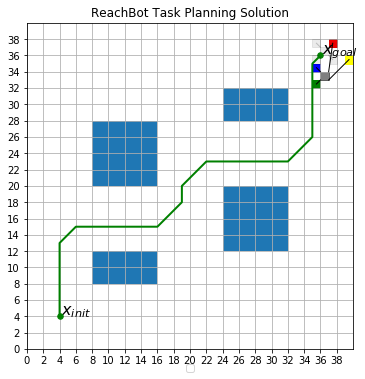

<Figure size 432x432 with 0 Axes>

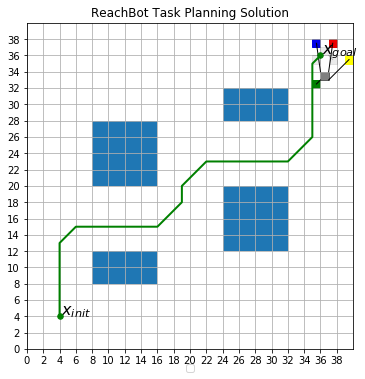

<Figure size 432x432 with 0 Axes>

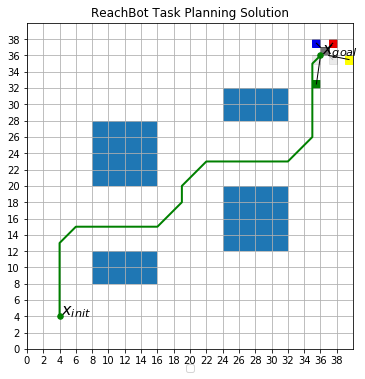

<Figure size 432x432 with 0 Axes>

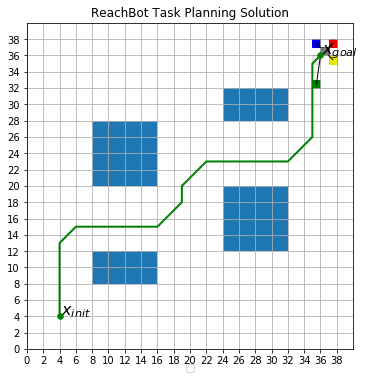

<Figure size 432x432 with 0 Axes>

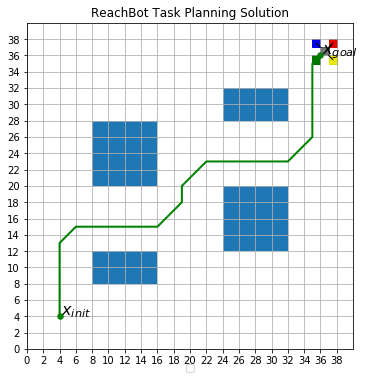

(16.03, 'seconds')
('Solved?', 'True')


<Figure size 432x432 with 0 Axes>

In [11]:
'''
# To run simpler problems, you can use a format like the one below, and pass in astar=None
x_map = [0, 10]
y_map = [0, 10]
state_init = state_from_body((1,1))
state_goal = state_from_body((9,9))
goals_list = [state_goal]
goals_remaining = copy.copy(goals_list)
'''

x_map = [0, width_sc]
y_map = [0, height_sc]
operators = ['move_foot1', 'move_foot2', 'move_foot3', 'move_foot4', 'move_body']

goals_list = []
for body_goal in subgoals:
    goals_list.append(state_from_body(body_goal))

goals_remaining = copy.copy(goals_list)
state_init = state_from_body(x_init_sc)

fig_num = 0
for state_goal in goals_list:
    solved, node, fig_num = solve_subproblem(x_map, y_map, state_init, state_goal, operators, fig_num, goals_remaining, astar=astar)
    goals_remaining.pop(0)
    state_init = state_goal
    print("Solved?", "True" if solved else "False")


## Random Cluttered Environment

### This was included in the A* assignment from AA274a. It is not yet modified to work with ReachBot.



### Generate workspace, start and goal positions
(Try changing these and see what happens)

In [ ]:
width = 100
height = 100
num_obs = 25
min_size = 5
max_size = 30

occupancy, x_init, x_goal = generate_planning_problem(width, height, num_obs, min_size, max_size)

### Run A* planning

In [ ]:
astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy)
if not astar.solve():
    print("No path found")
else:
    plt.rcParams['figure.figsize'] = [10, 10]
    astar.plot_path()
    astar.plot_tree(point_size=2)